<a href="https://colab.research.google.com/github/vivek8085/VOIS_AICTE_Oct2025_MajorProject_Vivek-Suresh-Lokolakar/blob/main/Netflix_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# load and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# for nicer plots
%matplotlib inline
plt.rcParams.update({'figure.figsize': (10,6), 'font.size': 12})
df = pd.read_csv('/content/Netflix Dataset.csv')
df.head()


,Show_Id,Category,Title,Director,Cast,Country,Release_Date,Rating,Duration,Type,Description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,07:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7789 entries, 0 to 7788
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Show_Id       7789 non-null   object
 1   Category      7789 non-null   object
 2   Title         7789 non-null   object
 3   Director      5401 non-null   object
 4   Cast          7071 non-null   object
 5   Country       7282 non-null   object
 6   Release_Date  7779 non-null   object
 7   Rating        7782 non-null   object
 8   Duration      7789 non-null   object
 9   Type          7789 non-null   object
 10  Description   7789 non-null   object
dtypes: object(11)
memory usage: 669.5+ KB


In [3]:
# === 1) Parse Release_Date ===
df['Release_Date_parsed'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=False)
if df['Release_Date_parsed'].isna().sum() / len(df) > 0.2:
    df['Release_Date_parsed'] = pd.to_datetime(df['Release_Date'], errors='coerce', dayfirst=True)

if df['Release_Date_parsed'].isna().sum() / len(df) > 0.1:
    df['Release_year_guess'] = df['Release_Date'].astype(str).str.extract(r'(\b\d{4}\b)', expand=False)
    df['Release_year_guess'] = pd.to_numeric(df['Release_year_guess'], errors='coerce').astype('Int64')
else:
    df['Release_year_guess'] = df['Release_Date_parsed'].dt.year.astype('Int64')

df['year_added'] = df['Release_Date_parsed'].dt.year.fillna(df['Release_year_guess']).astype('Int64')
print("Year added nulls:", df['year_added'].isna().sum())

Year added nulls: 98


In [4]:
# Top genres
genre_col = None
for candidate in ['listed_in','genres','genre','Category']:
    if candidate in df.columns:
        genre_col = candidate
        break
if genre_col:
    genres_series = df[genre_col].dropna().astype(str).str.split(',').explode().str.strip()
    print(genres_series.value_counts().head(20))


Category
Movie      5379
TV Show    2410
Name: count, dtype: int64


In [5]:
# Top countries
country_col = None
for candidate in ['country','Country','countries']:
    if candidate in df.columns:
        country_col = candidate
        break
if country_col:
    countries_series = df[country_col].dropna().astype(str).str.split(',').explode().str.strip()
    print(countries_series.value_counts().head(20))


Country
United States     3298
India              990
United Kingdom     723
Canada             412
France             349
Japan              287
Spain              215
South Korea        212
Germany            199
Mexico             154
China              147
Australia          144
Egypt              110
Turkey             108
Hong Kong          102
Italy               90
Brazil              88
Taiwan              85
Belgium             85
Argentina           82
Name: count, dtype: int64


In [6]:
# === 2) Detect which column is type vs genres ===
def looks_like_content_type(series):
    vals = set(series.dropna().astype(str).str.lower().unique())
    tokens = {'movie','tv show','tv','show','series'}
    return bool(vals & tokens)

cat_is_type = looks_like_content_type(df['Category'])
type_is_type = looks_like_content_type(df['Type'])

if type_is_type and not cat_is_type:
    content_col = 'Type'
    genre_col = 'Category'
elif cat_is_type and not type_is_type:
    content_col = 'Category'
    genre_col = 'Type'
else:
    content_col = 'Type'
    genre_col = 'Category'

print(f"Content-type column: {content_col}, Genre column: {genre_col}")



Content-type column: Category, Genre column: Type


In [7]:
# Normalize content_type
df['content_type'] = df[content_col].astype(str).str.strip()
df['content_type'] = df['content_type'].replace({
    'tv show':'TV Show','TV show':'TV Show','TV':'TV Show',
    'Movie':'Movie','movie':'Movie'
}).fillna('Unknown')

In [8]:
# === 3) Genres ===
df[genre_col] = df[genre_col].fillna('').astype(str).str.replace(';', ',', regex=False)
df['genre_list'] = df[genre_col].apply(lambda x: [g.strip() for g in x.split(',') if g.strip()] if x.strip() else [])
df_genre = df.explode('genre_list')
df_genre['genre_list'] = df_genre['genre_list'].replace('', np.nan)

In [9]:
# === 4) Countries ===
df['Country'] = df['Country'].fillna('').astype(str).str.replace(';', ',', regex=False)
df['country_list'] = df['Country'].apply(lambda x: [c.strip() for c in x.split(',') if c.strip()] if x.strip() else [])
df_country = df.explode('country_list')
df_country['country_list'] = df_country['country_list'].replace('', np.nan)

In [10]:
# === 5) Duration ===
dur_parsed = df['Duration'].astype(str).str.extract(r'(?P<num>\d+)\s*(?P<unit>\w+)', expand=True)
df['duration_num'] = pd.to_numeric(dur_parsed['num'], errors='coerce').astype('Int64')
df['duration_unit'] = dur_parsed['unit'].fillna('').str.lower()

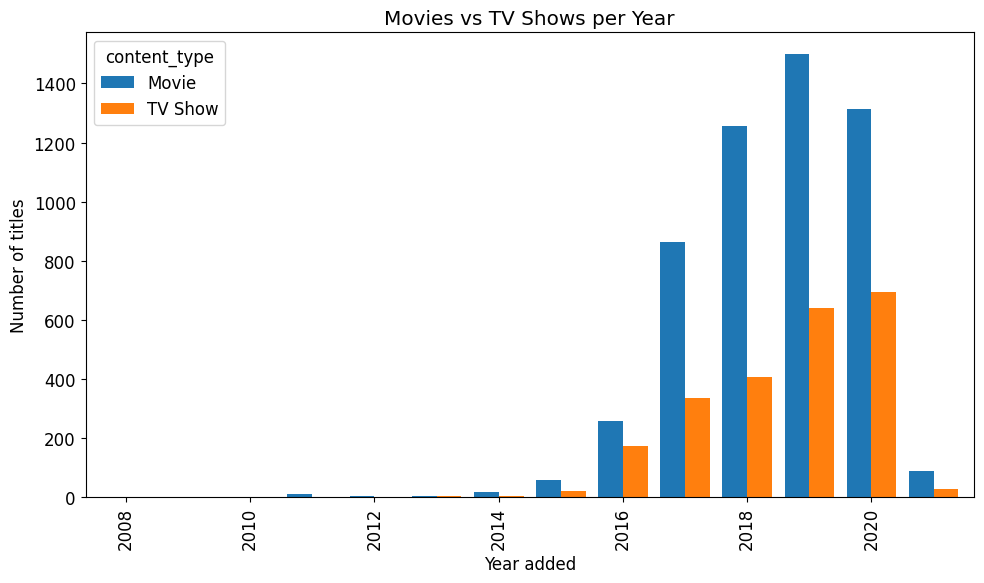

In [11]:
# === 6) Movies vs TV Shows per year ===
type_year = df.groupby(['year_added','content_type']).size().unstack(fill_value=0).sort_index()
type_year_plot = type_year.loc[type_year.index.notna()]

ax = type_year_plot.plot(kind='bar', width=0.8)
ax.set_xlabel('Year added')
ax.set_ylabel('Number of titles')
ax.set_title('Movies vs TV Shows per Year')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

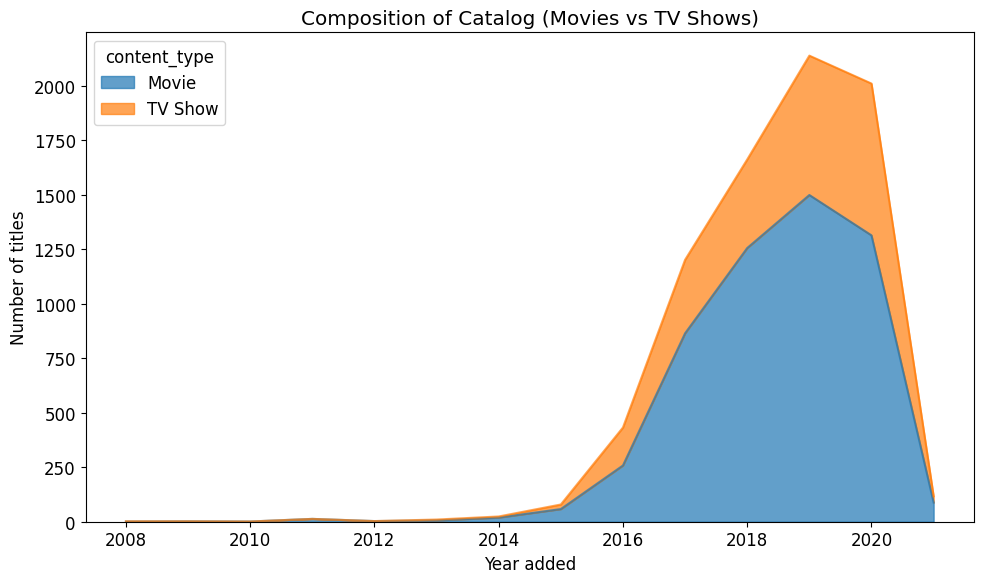

In [12]:
type_year_plot.plot(kind='area', stacked=True, alpha=0.7)
plt.title('Composition of Catalog (Movies vs TV Shows)')
plt.ylabel('Number of titles')
plt.xlabel('Year added')
plt.tight_layout()
plt.show()


Top 15 Genres:
 genre_list
International Movies        2437
Dramas                      2108
Comedies                    1472
International TV Shows      1199
Documentaries                786
Action & Adventure           721
TV Dramas                    704
Independent Movies           675
Children & Family Movies     532
Romantic Movies              531
TV Comedies                  525
Thrillers                    492
Crime TV Shows               427
Kids' TV                     414
Docuseries                   353
Name: count, dtype: int64


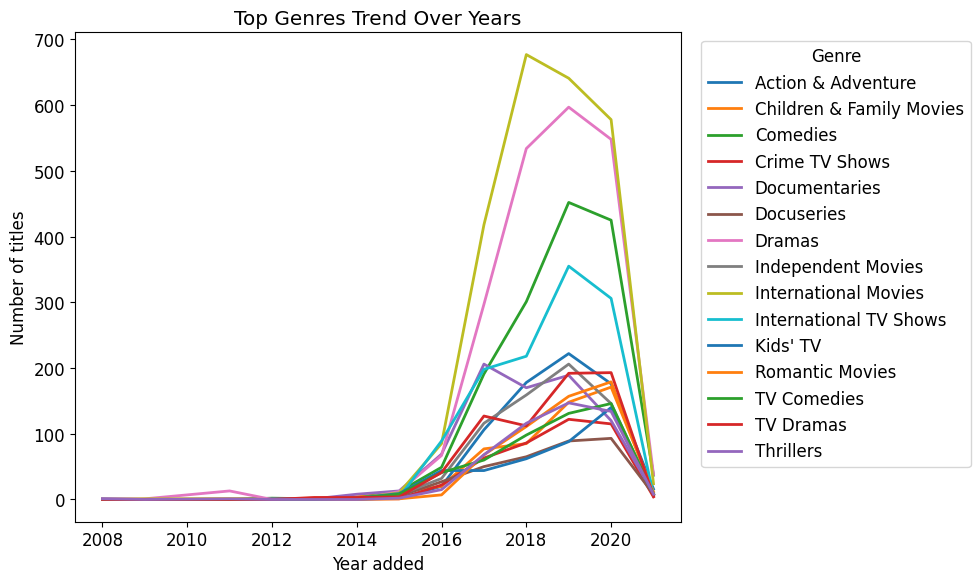

In [13]:
# === 7) Top Genres ===
top_genres = df_genre['genre_list'].value_counts().dropna().head(15)
print("\nTop 15 Genres:\n", top_genres)

if not top_genres.empty:
    topN = top_genres.index.tolist()
    genre_trends = df_genre[df_genre['genre_list'].isin(topN)].groupby(['year_added','genre_list']).size().unstack(fill_value=0).sort_index()
    genre_trends.plot(kind='line', linewidth=2)
    plt.title('Top Genres Trend Over Years')
    plt.xlabel('Year added')
    plt.ylabel('Number of titles')
    plt.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Top 20 Countries:
 country_list
United States     3298
India              990
United Kingdom     723
Canada             412
France             349
Japan              287
Spain              215
South Korea        212
Germany            199
Mexico             154
China              147
Australia          144
Egypt              110
Turkey             108
Hong Kong          102
Italy               90
Brazil              88
Taiwan              85
Belgium             85
Argentina           82
Name: count, dtype: int64


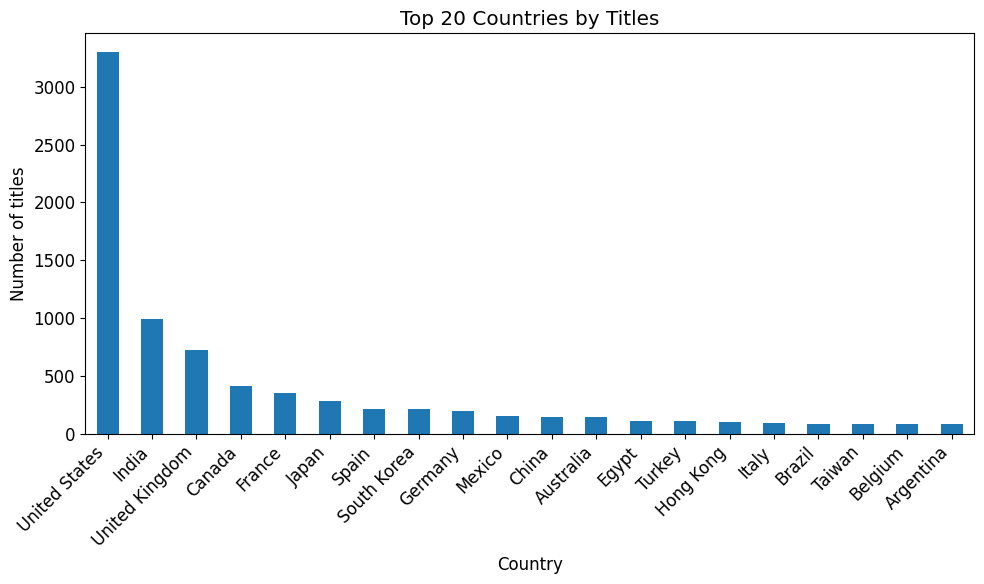

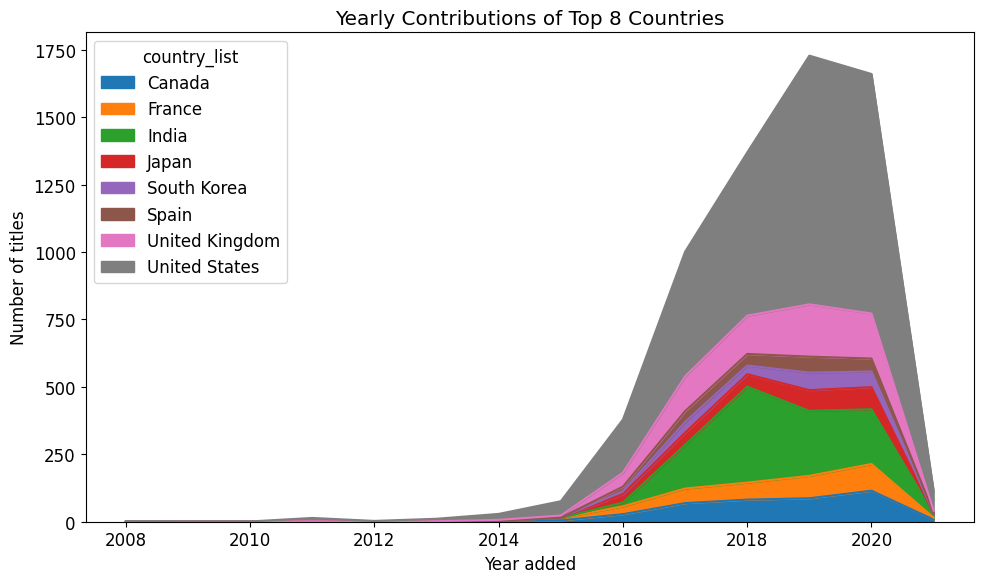

In [14]:
# === 8) Top Countries ===
top_countries = df_country['country_list'].value_counts().dropna().head(20)
print("\nTop 20 Countries:\n", top_countries)

if not top_countries.empty:
    top_countries.plot(kind='bar')
    plt.title('Top 20 Countries by Titles')
    plt.ylabel('Number of titles')
    plt.xlabel('Country')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    k = 8
    top_k = top_countries.head(k).index.tolist()
    country_trends = df_country[df_country['country_list'].isin(top_k)].groupby(['year_added','country_list']).size().unstack(fill_value=0).sort_index()
    country_trends.plot(kind='area', stacked=True)
    plt.title(f'Yearly Contributions of Top {k} Countries')
    plt.xlabel('Year added')
    plt.ylabel('Number of titles')
    plt.tight_layout()
    plt.show()


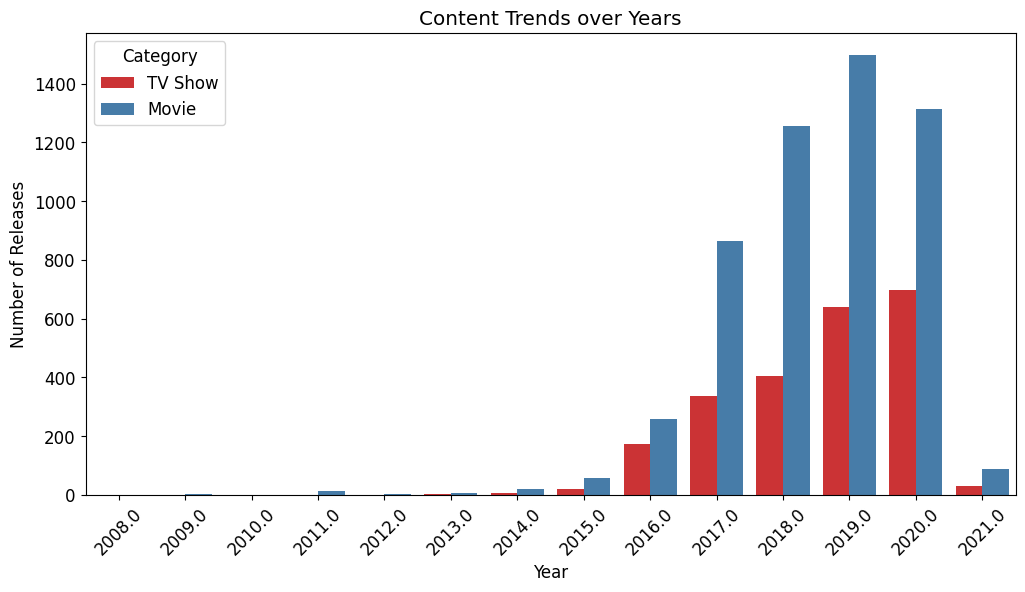

In [15]:
import seaborn as sns
df['Release_Date'] = pd.to_datetime(df['Release_Date'], errors='coerce')
df['Year'] = df['Release_Date'].dt.year

# Content Trends over Years
plt.figure(figsize=(12,6))
sns.countplot(x='Year', data=df, hue='Category', palette="Set1")
plt.title("Content Trends over Years")
plt.xlabel("Year")
plt.ylabel("Number of Releases")
plt.xticks(rotation=45)
plt.legend(title="Category")
plt.show()

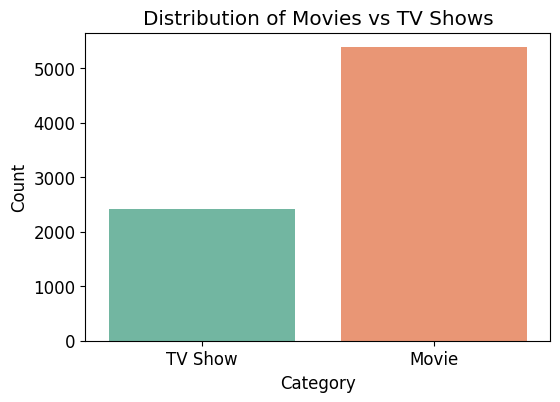

In [16]:
# Movies vs TV Shows Count
plt.figure(figsize=(6,4))
sns.countplot(x='Category', data=df, hue='Category', palette="Set2", legend=False)
plt.title("Distribution of Movies vs TV Shows")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


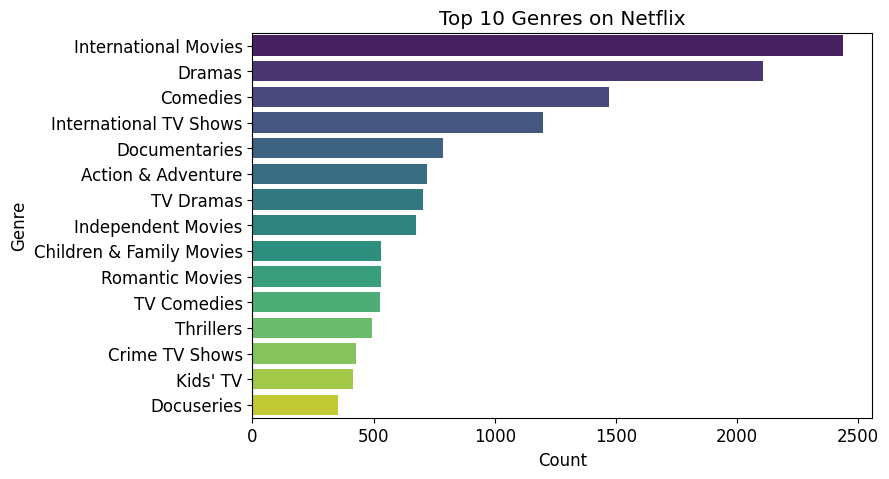

In [17]:
#  Top Genres
plt.figure(figsize=(8,5))
sns.barplot(x=top_genres.values, y=top_genres.index, hue=top_genres.index, dodge=False, palette="viridis", legend=False)
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

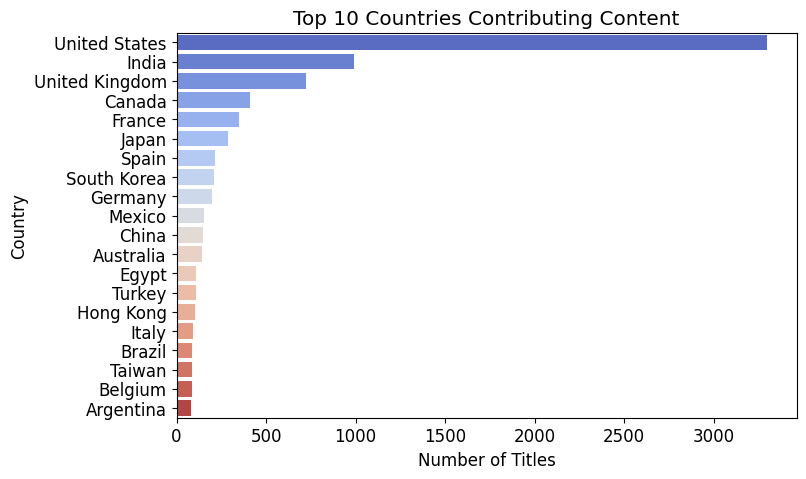

In [18]:
# Country-wise Contribution
plt.figure(figsize=(8,5))
sns.barplot(x=top_countries.values, y=top_countries.index, hue=top_countries.index, dodge=False, palette="coolwarm", legend=False)
plt.title("Top 10 Countries Contributing Content")
plt.xlabel("Number of Titles")
plt.ylabel("Country")
plt.show()

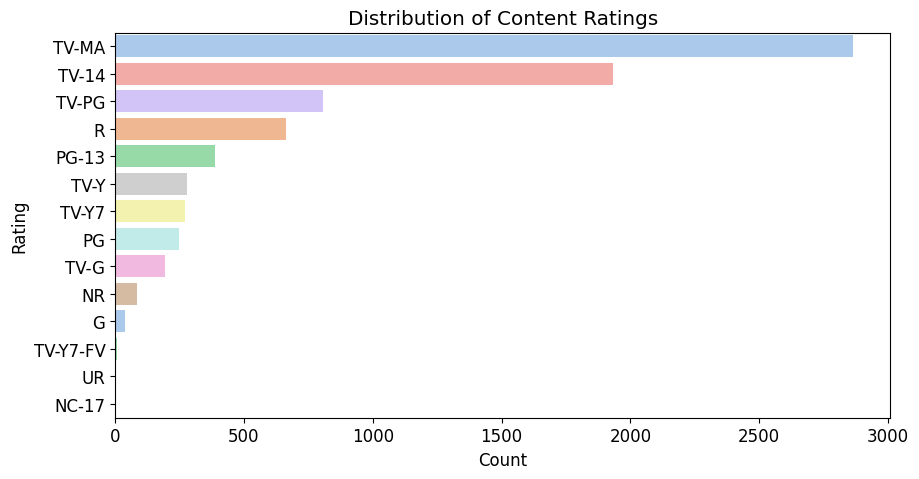

In [19]:
# Ratings Distribution
plt.figure(figsize=(10,5))
sns.countplot(y='Rating', data=df, order=df['Rating'].value_counts().index,
              hue='Rating', dodge=False, palette="pastel", legend=False)
plt.title("Distribution of Content Ratings")
plt.xlabel("Count")
plt.ylabel("Rating")
plt.show()